Hello! Today we will be using mock light curves from Fagin et al. (2025, https://ui.adsabs.harvard.edu/abs/2024arXiv241018423F/abstract) to explore what we can do with Rubin AGN light curves! We will start by loading in the light curves from Fagin et al. (2025) and then adding the Rubin cadence and errors to these light curves so that we can study how the Rubin cadence might impact our ability to study these light curves.

# Required python packages (pip install)

matplotlib, numpy, glob, astropy, pandas, sqlite3, eztao (pip install git+https://github.com/ywx649999311/EzTao.git), scipy, celerite, numba, emcee



In [1]:
#import some genral packages we will need

import numpy as np
import matplotlib.pyplot as plt
import glob
from astropy.io import fits

In [54]:
#load in the mock light curves from Fagin et al. (2025)

directory='light_curves'
files = sorted(glob.glob(directory+"/*.fits"))
print(f"number of saved light curves: {len(files)}")

number of saved light curves: 100


In [3]:
# Load all the light curves
bands = list("ugrizy")

all_data = []
for fname in files:
    with fits.open(fname) as hdul:
        # Primary = Light curve observed every day at daily intervals
        LC_time = []
        LC_mag = []
        LC_mag_error = []
        for band in bands:
            LC = hdul[f"{band.upper()}_BAND"].data
            time = LC[:, 0]
            mag = LC[:, 1]
            mag_error = LC[:, 2]
            LC_time.append(time)
            LC_mag.append(mag)
            LC_mag_error.append(mag_error)
        LC_time = np.stack(LC_time, axis=1)
        LC_mag = np.stack(LC_mag, axis=1)
        LC_mag_error = np.stack(LC_mag_error, axis=1)
        parameters=hdul[0].header

    all_data.append({
        'LC_time':           LC_time, 
        'LC_mag':            LC_mag,
        'LC_mag_error':      LC_mag_error,
        'parameters':       parameters
    })

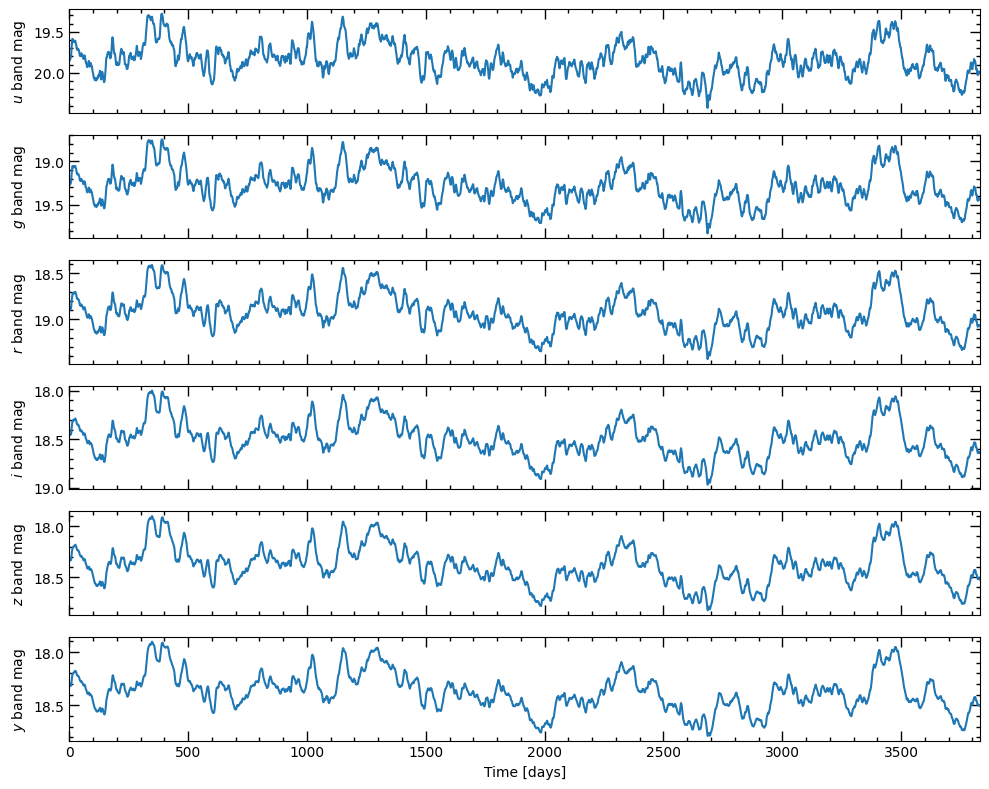

In [7]:
# Create a single row of 6 subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 8), sharex=True, sharey=False)

time = all_data[89]['LC_time']
mag = all_data[89]['LC_mag']


for idx, ax in enumerate(axes):
    ax.plot(time[:, idx], mag[:, idx],    label='True', linewidth=1.5)
    ax.set_ylabel(f'${bands[idx]}$ band mag')
    ax.set_xlim(time[:, idx][0],time[:, idx][-1])
    ax.minorticks_on()
    ax.tick_params(which='major', direction='in', top=True, right=True, length=7, width=1)
    ax.tick_params(which='minor', direction='in', top=True, right=True, length=3, width=1)
    ax.invert_yaxis()

plt.xlabel('Time [days]')
plt.tight_layout()
plt.show()

Great! Now that we have a light curve we want to add the LSST time sampling and noise. We will need to download the latest simulated Rubin cadence. Please download baseline_v4.3.5_10yrs.db from https://community.lsst.org/t/announcing-new-ocean-ddf-survey-strategy-simulation/10162

In [8]:
#First read in opsim database, with observing dates, mag errors, and science program

import pandas as pd
import sqlite3

try:
    conn = sqlite3.connect("baseline_v4.3.5_10yrs.db")
except Error as e:
    print(e)

df = pd.read_sql_query('SELECT fieldRA, fieldDec, seeingFwhmEff, observationStartMJD, filter, fiveSigmaDepth, skyBrightness, science_program FROM observations', conn)
conn.close()


In [9]:
#Methods to add in LSST sampling and noise

bandpasses = list("ugrizy")

def LSST_photometric_noise(mag,m_5s,band_num):
    #https://arxiv.org/pdf/2203.09540.pdf good paper for reference
    #They assume sigma_sys = 0.004 mag since its expected sigma_sys < 0.005 mag

    gammas = [0.038, 0.039, 0.039, 0.039, 0.039, 0.039]
    gamma = gammas[band_num]

    x = 10.0 ** (0.4 * (mag - m_5s))
    sigma_rand = np.sqrt((0.04 - gamma)*x + gamma*(x**2))

    return sigma_rand

def get_observed_LC(LC, ddf=False, min_magnitude=13.0, max_magnitude=25.0):
    """
    This function takes in a light curve at a fixed cadence and returns an observed light curve
    using LSST sampling and photometric noise.

    LC: numpy array, light curve with fixed cadence in units of magnitude
    ddf: boolean, True if you want a DDF, False if you want WFD

    returns: numpy array, observed light curve, numpy array, photometric noise
    """

    time_list = []
    m_5s_list = []


    if ddf==True:
        field_db=df.where(df['science_program']=='DD').dropna()

    if ddf==False:
        field_db=df.where(df['science_program']!='DD').dropna()

    #pick a random RA/DEC that's in the desired science program and pick 
    #out all observations within that FOV
    dlen=0
    while dlen<200:
        rint=np.random.randint(len(field_db))
        ra=field_db['fieldRA'].values
        dec=field_db['fieldDec'].values
        new_db = field_db.where((np.abs(field_db['fieldRA'] - ra[rint])<0.75) & \
                (np.abs(field_db['fieldDec'] - dec[rint])<0.75) ).dropna()
        times = new_db['observationStartMJD'].dropna().values
        filters = new_db['filter'].dropna().values
        m_5s = new_db['fiveSigmaDepth'].dropna().values
        dlen=len(times)
    times-=min(times)

    for i,band in enumerate(bandpasses):
        idx1 = np.argwhere(filters == band)
        time_list.append(np.round(times[idx1]).astype(np.int64))
        m_5s_list.append(m_5s[idx1])

    utimes = np.zeros(LC.shape)
    LC_obs = np.zeros(LC.shape)
    stdev = np.zeros(LC.shape)
    nutimes=[]
    nstdev=[]
    nLC_obs=[]
    
    for i in range(len(bandpasses)):
        time = time_list[i]
        m_5s = m_5s_list[i]
        
        sigma_list = []
        for j,t in enumerate(time):
            mag = LC[t]
            sigma = LSST_photometric_noise(mag,m_5s[j],i)
            sigma_list.append(sigma)
        sigma_list = np.array(sigma_list)

        time_unique,index_unique = np.unique(time,return_index=True)
        sigma_unique = []
        for j in range(len(index_unique)):
            if j+1 < len(index_unique):
                sigma_list_at_t = sigma_list[index_unique[j]:index_unique[j+1]]
            else:
                sigma_list_at_t = sigma_list[index_unique[j]:]

            # combine the photoemtric noise such that the final noise is lower than the individual noise
            new_sigma = 1/np.sqrt(np.sum(1/sigma_list_at_t**2))
            sigma_unique.append(new_sigma)

        sigma_unique = np.array(sigma_unique)

        #adding systematic and rand errors in quadrature to the photometric noise
        sigma_sys = 0.005
        sigma_unique = np.sqrt(sigma_sys**2 + sigma_unique**2)

        # We clip the photometric noise to have a maximum value of 1 mag, can lead to problems if the noise is too large
        sigma_unique = np.clip(sigma_unique,None,1.0)

        for t, sigma in zip(time_unique,sigma_unique):
            # We only include observations that are within the magnitude range of LSST!
            random_noise = np.random.normal(0.0, sigma)

            # Only include observations that are within the magnitude range of LSST
            if min_magnitude <= LC[t,i] + random_noise <= max_magnitude:
                utimes[t,i]=t
                stdev[t,i] = sigma
                LC_obs[t,i] = LC[t,i] + random_noise

        #remove unobserved times (zeros), makes it an inhomogenous list
        mask = LC_obs[:,i] == 0.0
        tutimes=np.delete(utimes[:,i],mask)
        nutimes.append(tutimes)
        tstdev=np.delete(stdev[:,i],mask)
        nstdev.append(tstdev)
        tLC_obs=np.delete(LC_obs[:,i],mask)
        nLC_obs.append(tLC_obs)    



        
    return nutimes,nLC_obs, nstdev

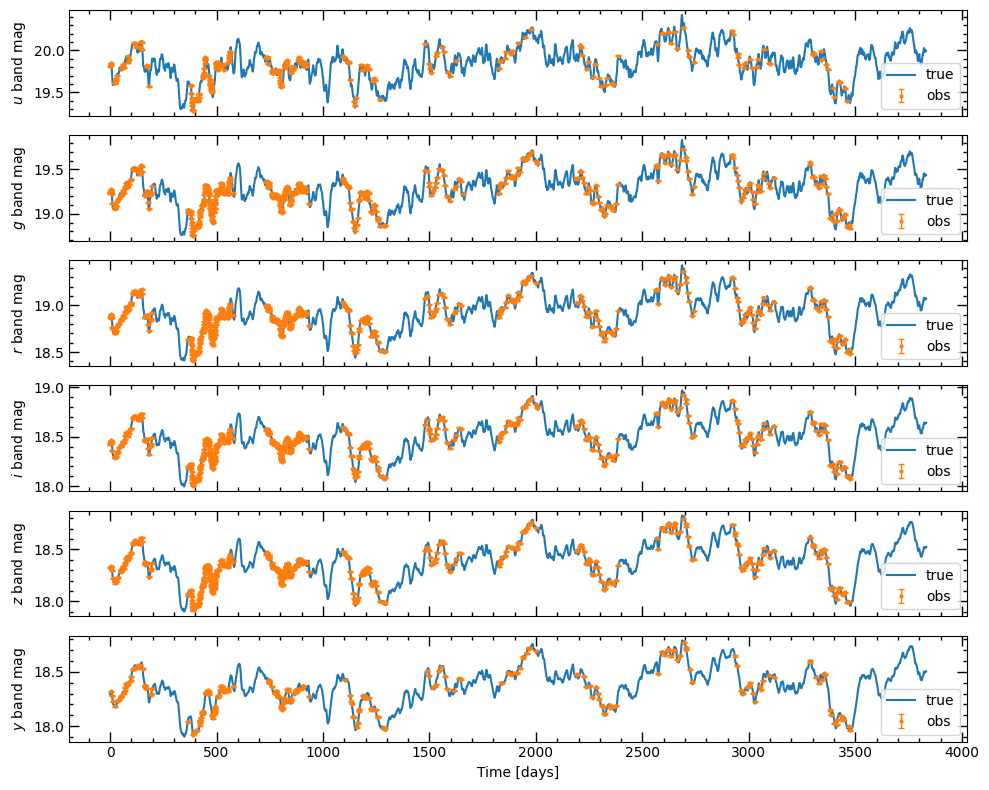

In [11]:
#use the methods in the cell above to add LSST sampling and noise to one of the Fagin light curves

#select the 90th light curve
time = all_data[89]['LC_time']
mag = all_data[89]['LC_mag']




LC_times, LC_obs_mean, LC_obs_stdev = get_observed_LC(LC=mag,
                                            ddf=True,
                                            min_magnitude=-100, 
                                            max_magnitude=100
                                           )

# Create a single row of 6 subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 8), sharex=True, sharey=False)



for idx, ax in enumerate(axes):
    ax.plot(time[:, idx], mag[:, idx],    label='true', linewidth=1.5)
    ax.errorbar(LC_times[idx], LC_obs_mean[idx], yerr=LC_obs_stdev[idx],  label='obs', fmt='o', markersize=2, elinewidth=1, capsize=2)
    ax.set_ylabel(f'${bands[idx]}$ band mag')
    #ax.set_xlim(LC_times[0],LC_times[-1])
    ax.minorticks_on()
    ax.tick_params(which='major', direction='in', top=True, right=True, length=7, width=1)
    ax.tick_params(which='minor', direction='in', top=True, right=True, length=3, width=1)
    ax.legend()

plt.xlabel('Time [days]')
plt.tight_layout()

Great! Now we have mock Rubin AGN light curves. One of the first thing we will want to do with Rubin AGN light curves is to study the power specturm of their variability. One particular way we do this is to fit a damped random walk model to the AGN light curve. Because our light curve does not have an even cadence we can not just perform an FFT to look at the power spectrum. Instead we will use a code EzTao that has been specifically designed to fit damped random walk models to AGN light curves.

In [11]:
#import eztao and the neccessary modules from eztao
import eztao
from eztao.ts import drw_fit
from eztao.carma import DRW_term
from eztao.carma import gp_psd

In [12]:
#fit the full g-band light curve with a DRW model
best_fit_real = drw_fit(time[:,1], mag[:,1],np.zeros(len(mag[:,1])))
print(f'Best-fit structure function: {np.round(best_fit_real[0],2)}  Best-fit damping timescale: {np.round(best_fit_real[1])}')

# define the true PSD functions using
# a new kernel initalized with the best-fit parameters
best_fit_kernel_real = DRW_term(*np.log(best_fit_real))
true_psd = gp_psd(best_fit_kernel_real)

Best-fit structure function: 0.19  Best-fit damping timescale: 306.0


In [13]:
#fit the g-band light curve sub-sampled with the Rubin cadence with a DRW model
best_fit = #TODO
print(f'Best-fit structure function: {np.round(best_fit[0],2)}  Best-fit damping timescale: {np.round(best_fit[1])}')

# define the true PSD functions using
# a new kernel initalized with the best-fit parameters
best_fit_kernel = #TODO
best_psd = #TODO

Best-fit structure function: 0.18  Best-fit damping timescale: 70.0


Let's plot the two PSDs to compare them.

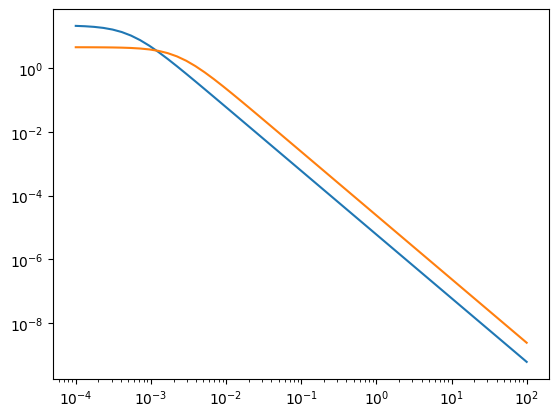

In [14]:
fig=plt.figure()
freq = np.logspace(-4, 2)
plt.plot(freq,true_psd(freq))
plt.plot(freq,best_psd(freq))

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

A common way of measuring the radial extent and radial temperature profile of an AGN disk to find the interpolated cross correlation function (Peterson, 2004). To do so we first need to linearly interpolate the data baxck to a daily cadence.

In the cell below linearly interpolate the g-band light curve back to a daily cadence and plot and compare the interpolated data to the true light curve.

Now linearly interpolate the z-band light curve back to a daily cadence and plot and compare the interpolated data to the true light curve.

In the cell below plot and comapre your interpolated u-band and y-band light curve. You may want to normalize each light curve by diving them by their mean magnitudes in order to normalize them for easier comparison.

Adjust your x-axis limits to take a closer look at the first 100 days of data. Can you see by eye that the longer wavelength band (the z-band) is lagging the g-band? Can you shift the time of the z-band light curve by subtracting a value from the time to predict by eye what lag you anticipate?

Now that we have linearly interpolated the data and made a by eye prediction we will do the cross correlation. You can use scipy.stats.pearsonr to calculate the pearson r-coefficient between the two light curves:

In [21]:
from scipy.stats import pearsonr

pearsonr(imag1,imag4)

PearsonRResult(statistic=0.9805536011953339, pvalue=0.0)

The Pearson r-coefficient is very strong between the two light curves even if we do not shift them. Now we will want to shift the z-band light curve forward by different one day intervals to try and find the shift that produces the highest r-coefficient. For example:

In [22]:
pearsonr(imag1[:-1],imag4[1:])

PearsonRResult(statistic=0.9830517802045677, pvalue=0.0)

The r-coefficient is slightly larger if we shift the z-band light curve forward one day. Play around yourself and see what shift gives the largest r-coefficent. Save the r-coefficients in the numpy array rcoeff so that you can plot them in the following cell.

In [31]:
rcoeff=np.zeros(11)

Text(0, 0.5, 'R-coefficient')

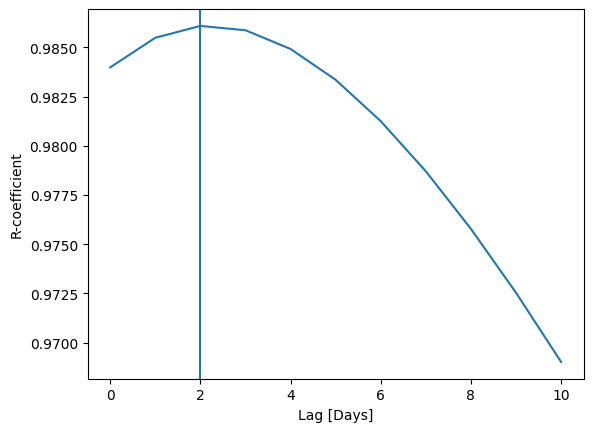

In [52]:
#plot the R-coefficient as a function of lag

fig=plt.figure()
plt.plot(np.arange(11),rcoeff)
plt.axvline(np.arange(11)[np.argmax(rcoeff)])
plt.xlabel('Lag [Days]',fontsize=10)
plt.ylabel('R-coefficient',fontsize=10)

That worked pretty well! See if you can play around with:
1) Some of the other waveband light curves. How do the lags scale between the g-band and other wavebands? How do DRW parameters change for the same light curve but different wavebands?
2) With a different light curve by indexing a different light curve to sub-sample with the Rubin cadence. Can EzTao fit a DRW model to all of the mock light curves?
3) How well does all of this work for the wide fast deep field? Check by setting ddf=False.
4) If you have time try out the machine learning code that does this.